In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()

In [2]:
save_file_name = os.path.join('temp','temp_spam_data.csv')
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1 if x=='spam' else 0 for x in target]

In [3]:
texts = [x.lower() for x in texts]
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
texts = [' '.join(x.split()) for x in texts]

In [4]:
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
sentence_size = 25
min_word_freq = 3

In [5]:
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)

In [6]:
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [7]:
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

In [8]:
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

In [9]:
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

In [10]:
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

In [11]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))
prediction = tf.sigmoid(model_output)
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

In [12]:
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 4459 Sentences.
Training Observation #10: Loss = 0.506898
Training Observation #20: Loss = 3.81301
Training Observation #30: Loss = 0.355434
Training Observation #40: Loss = 0.00821354
Training Observation #50: Loss = 0.0805953
Training Observation #60: Loss = 0.0576558
Training Observation #70: Loss = 0.0153128
Training Observation #80: Loss = 0.0127036
Training Observation #90: Loss = 2.00682
Training Observation #100: Loss = 0.0460043
Training Observation #110: Loss = 0.0109576
Training Observation #120: Loss = 5.72528
Training Observation #130: Loss = 0.00832923
Training Observation #140: Loss = 0.00665702
Training Observation #150: Loss = 0.0105412
Training Observation #160: Loss = 0.00838606
Training Observation #170: Loss = 2.15429
Training Observation #180: Loss = 3.9443
Training Observation #190: Loss = 0.000100375
Training Observation #200: Loss = 0.734045
Training Observation #210: Loss = 0.056169
Training Observation #220: Loss = 2.25785e-06
Training 

Training Observation #1860: Loss = 3.44514
Training Observation #1870: Loss = 0.869318
Training Observation #1880: Loss = 1.62958e-06
Training Observation #1890: Loss = 0.220566
Training Observation #1900: Loss = 0.0299564
Training Observation #1910: Loss = 3.41183
Training Observation #1920: Loss = 3.22459e-05
Training Observation #1930: Loss = 1.47216e-05
Training Observation #1940: Loss = 4.07214e-06
Training Observation #1950: Loss = 0.866478
Training Observation #1960: Loss = 4.48356e-06
Training Observation #1970: Loss = 0.0211716
Training Observation #1980: Loss = 0.135092
Training Observation #1990: Loss = 0.13763
Training Observation #2000: Loss = 9.3294
Training Observation #2010: Loss = 8.22131
Training Observation #2020: Loss = 0.732771
Training Observation #2030: Loss = 1.79193
Training Observation #2040: Loss = 0.000407309
Training Observation #2050: Loss = 0.00118143
Training Observation #2060: Loss = 1.04813e-05
Training Observation #2070: Loss = 8.05509e-05
Training Ob

Training Observation #3680: Loss = 0.00143415
Training Observation #3690: Loss = 0.00622355
Training Observation #3700: Loss = 0.000849533
Training Observation #3710: Loss = 5.7147e-05
Training Observation #3720: Loss = 9.47656e-05
Training Observation #3730: Loss = 0.00152313
Training Observation #3740: Loss = 4.00341e-05
Training Observation #3750: Loss = 0.0261611
Training Observation #3760: Loss = 0.00141383
Training Observation #3770: Loss = 0.00619028
Training Observation #3780: Loss = 0.183325
Training Observation #3790: Loss = 0.428427
Training Observation #3800: Loss = 0.436703
Training Observation #3810: Loss = 6.765
Training Observation #3820: Loss = 0.00150894
Training Observation #3830: Loss = 3.91251e-05
Training Observation #3840: Loss = 0.0193604
Training Observation #3850: Loss = 0.000298647
Training Observation #3860: Loss = 0.000137359
Training Observation #3870: Loss = 0.00612465
Training Observation #3880: Loss = 0.000402474
Training Observation #3890: Loss = 0.059

Getting Test Set Accuracy For 1115 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.8152466367713005


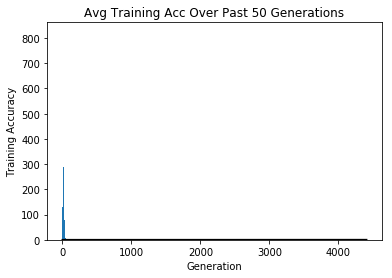

In [14]:
print('Getting Test Set Accuracy For {} Sentences.'.format(len(texts_test)))
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    if (ix+1)%50==0:
        print('Test Observation #' + str(ix+1))
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)
print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Generations')
plt.xlabel('Generation')
plt.ylabel('Training Accuracy')
plt.show()